### Pytorch 설치

In [ ]:
'''
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
'''

     |████████████████████████████████| 591.8 MB 671 bytes/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.7 MB/s 
     |████████████████████████████████| 23.3 MB 49.2 MB/s 
     |████████████████████████████████| 23.3 MB 38.3 MB/s 
     |████████████████████████████████| 22.1 MB 60.5 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 608 kB/s 
     |████████████████████████████████| 17.3 MB 112 kB/s 
     |████████████████████████████████| 12.8 MB 18 kB/s 
     |████████████████████████████████| 12.7 MB 32.7 MB/s 
     |████████████████████████████████| 11.8 MB 23.8 MB/s 
     |████████████████████████████████| 5.9 MB 30.3 MB/s 
     |████████████████████████████████| 6.6 MB 21.0 MB/s 
     |████████████████████████████████| 6.6 MB 20.6 MB/s 
     |████████████████████████████████| 4.0 MB 34.8 MB/s 
     |████████████████████████████████| 10.2 MB 31.4 MB/s 
     

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
import numpy as np

## 0.1. torchvision

- 일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 `torch.*Tensor` 로 변환합니다.

- 특별히 영상 분야를 위한 `torchvision` 이라는 패키지가 만들어져 있는데, 여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 `torchvision.datasets` 과 이미지용 데이터 변환기 (data transformer), 즉 `torch.utils.data.DataLoader` 가 포함되어 있습니다.



# 1. Data Preparation (Load and normalize CIFAR10)

* `torchvision`을 사용하여 CIFAR10의 학습용/시험용 데이터셋을 불로오고, 정규화(normalizing) 합니다.


In [ ]:
# transforms.Compose: 데이터를 전처리해주는 패키지
transform = transforms.Compose(
    # image 파일을 tensor로 transformation을 해줌
    [transforms.ToTensor(),
     # .ToTensor()로 타입을 변경하면 픽셀 값 하나가 0~1 사이로 scale됨
     # transforms.Normalize: 전체 distribution을 0.5 씩 shift 해주고(-0.5 ~ 0.5), 다시 0.5로 나눠줌(-1 ~ 1)
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# CIFAR10 데이터셋을 가져옴
trainset = torchvision.datasets.CIFAR10(
    root='./data',         # 데이터 저장 위치
    train=True,            # True: train set, False: test set
    download=True,         # 다운로드 여부, (이미 다운로드 받았으면 False로 지정하면 된다)
    transform=transform    # 데이터 전처리 작업
  )
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000]) # train set(50000)을 train set(40000), validation set(10000)으로 split
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

# torchvision.datasets 의 데이터들을 불러온다
trainloader = torch.utils.data.DataLoader(
    trainset,              # 불러올 데이터셋
    batch_size=batch_size, # batch 단위만큼 데이터를 뽑아옴
    shuffle=True,          # 데이터를 shuffle 할 것인지(epoch 마다 데이터셋을 섞어서 데이터가 학습되는 순서를 바꾼다) --> train 시에는 True 로 설정하는 것을 권장
    num_workers=2          # 데이터 로딩에 사용하는 subprocess 개수(multi-processing)
)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 재미삼아 보는 학습용 이미지

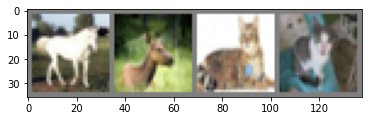

horse deer  cat   cat  
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([7, 4, 3, 3])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

print(type(images), images.shape)
print(type(labels), labels.shape, labels)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define a Convolutional Neural Network


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__() 
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList() # 모듈을 담아주는 리스트(파이토치 프레임워크가 리스트 안에 담긴 것들이 모듈들이라는 것을 인식함)

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim)) # layer 들을 append
        # 마지막 layer에 activation function을 통과시키지 않기 위해서 따로 빼줌
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # activation function
        if self.act == 'relu':
            self.act = nn.ReLU() 
 
    def forward(self, x):
        x = self.act(self.fc(x)) # activation function 을 통과
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x) # 마지막 layer
        return x # CNN 을 거친 output 값

net = MLP(3072, 10, 100, 4, 'relu') # fully connected layers 수가 4인 convolution neural network가 정의됨
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


# 3. Define Experiment

* loss function, optimizer 정의
* train data를 사용하여 신경망을 학습
* validation data 를 사용하여 신경망을 검증
* test data를 사용하여 신경망을 검사

In [ ]:
def experiment(args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda() # model의 parameter를 GPU에 loading
    print(net)

    criterion = nn.CrossEntropyLoss() # 손실함수(Cross-Entropy loss)
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm) # Optimizer(momentum 값을 갖는 SGD)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ===== Train ===== #
        net.train() # model을 train 모드로 전환
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # gradient를 0으로 초기화, Pytorch에서는 gradients값들을 추후에 backward를 해줄때 계속 더해주기 때문
            optimizer.zero_grad() 

            # [inputs, labels]의 목록인 data로부터 입력을 받음
            inputs, labels = data

            # print(inputs.shape) --> torch.Size([4, 3, 32, 32])
            # .view(-1, 3072) --> (4 * 3 * 32 * 32) / 3072 = 4 
            inputs = inputs.view(-1, 3072) # reshape 해줌
            # print(inputs.shape) --> torch.Size([4, 3072])
            
            inputs = inputs.cuda()
            labels = labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # gradient 저장
            optimizer.step() # gradient 만큼 parameter를 조정

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                

        # ====== Validation ====== #
        net.eval()

        correct = 0
        total = 0
        val_loss = 0 
        # 학습 중이 아니므로, 출력에 대한 gradient를 계산할 필요가 없음
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072) # 크기를 맞춰줘야함
                
                images = images.cuda()
                labels = labels.cuda()

                # 신경망에 이미지를 통과시켜 출력을 계산
                outputs = net(images)

                loss = criterion(outputs, labels) # cross-entropy 를 통해 loss 를 구함
                val_loss += loss.item()

                # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0) 
                correct += (predicted == labels).sum().item() 

            # len(valloader): batch size가 4이기 때문에 10000/4 = 2500
            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))


    # ===== Evaluation ===== #
    net.eval()
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc
    

# 4. Experiment

## 4.1. seed
#### 📌 seed 를 사용해야하는 이유: <br>
- hyperparameter 값을 바꿀 때 결과 값을 보면서 값을 조금씩 바꾸는데,
만일 seed를 고정해두지 않으면 hyperparameter를 바꾸면서 결과를 모니터링 했을 때 이게 hyperparameter 때문에 바뀐건지 random으로 파라미터가 초기화가 돼서 starting point가 이상한 곳에서 시작해서인건지 두 가지의 영향이 미치기 때문에 어떤 이유 때문에 결과값이 변화한건지 파악하기 힘들다.

- 즉, 모델이 random으로 초기화되니까 그걸 같은 지점에서 starting point를 만들어주는 것

In [3]:
# ====== Seed 사용 X ====== #
a = np.random.rand()
print(a)
# 계속 random한 값이 나옴

0.7360975838033684


In [ ]:
# ====== Seed 사용 O ====== #
seed = 123 # 아무 값이나 넣어도 됨
np.random.seed(seed)
a = np.random.rand()
print(a)

0.6964691855978616


In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed) # manual_seed(): pytorch에서 제공하는 random seed를 고정하기 위한 함수

parser = argparse.ArgumentParser() # parser 생성
args = parser.parse_args("") 

# hyper parameter set 정의
args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9

args.epoch = 2

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)


MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.179
[1,  4000] loss: 1.885
[1,  6000] loss: 1.770
[1,  8000] loss: 1.716
[1, 10000] loss: 1.711
Epoch 0, Train Loss: 18522.40516498685, Val Loss: 1.6506811730027198, Val Acc: 40.71
[2,  2000] loss: 1.626
[2,  4000] loss: 1.606
[2,  6000] loss: 1.584
[2,  8000] loss: 1.595
[2, 10000] loss: 1.562
Epoch 1, Train Loss: 15947.464552089572, Val Loss: 1.5749206317543984, Val Acc: 43.92
(15947.464552089572, 1.5749206317543984, 43.92, 44.21)
MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_